In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# 1. Data Downloading and Preparation
def download_data(max_retries=3, delay=5):
    ticker = "^GSPC"  # S&P 500 index
    for attempt in range(max_retries):
        try:
            data = yf.download(ticker, start="2018-01-01", end="2023-12-30")['Close']
            if data.empty:
                raise ValueError("Downloaded data is empty.")
            print(f"Successfully downloaded {len(data)} data points.")
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(delay)  # Wait before retrying
            else:
                raise Exception("Max retries reached. Could not download data. Check ticker or network.")

def prepare_data(data, window_size=3):
    if len(data) == 0:
        raise ValueError("No data available to process.")
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i + window_size])
        y.append(scaled_data[i + window_size])
    
    X = np.array(X)
    y = np.array(y)
    # Split into train (2018-01-01 to 2022-01-29) and test (2022-01-30 to 2023-12-29)
    train_size = int(len(X) * 0.68)  # Approx 68% as per paper
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler

In [5]:
# 2. Model Definitions
def build_lstm():
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(3, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn():
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=(3, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_ann():
    model = Sequential([
        Dense(50, activation='relu', input_shape=(3, 1)),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_rnn():
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=(3, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru():
    model = Sequential([
        GRU(50, activation='tanh', input_shape=(3, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
# 3. Performance Metrics
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred, epsilon=1e-10):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def calculate_directional_accuracy(y_true, y_pred):
    direction_true = np.sign(y_true[1:] - y_true[:-1])
    direction_pred = np.sign(y_pred[1:] - y_pred[:-1])
    return np.mean((direction_true == direction_pred)) * 100

In [7]:
# 4. Training and Evaluation
def train_and_evaluate(model, X_train, X_test, y_train, y_test, scaler, model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=500, batch_size=128, 
                        validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    
    # Predictions
    y_train_pred = model.predict(X_train, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)
    
    # Inverse transform predictions
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    rmse_train = calculate_rmse(y_train_true, y_train_pred)
    rmse_test = calculate_rmse(y_test_true, y_test_pred)
    mape_train = calculate_mape(y_train_true, y_train_pred)
    mape_test = calculate_mape(y_test_true, y_test_pred)
    da_train = calculate_directional_accuracy(y_train_true.flatten(), y_train_pred.flatten())
    da_test = calculate_directional_accuracy(y_test_true.flatten(), y_test_pred.flatten())
    
    print(f"\n{model_name} Results:")
    print(f"RMSE Train: {rmse_train:.4f}, RMSE Test: {rmse_test:.4f}")
    print(f"MAPE Train: {mape_train:.4f}%, MAPE Test: {mape_test:.4f}%")
    print(f"Directional Accuracy Train: {da_train:.2f}%, Test: {da_test:.2f}%")
    
    return y_train_pred, y_test_pred, history

In [8]:
# 5. Main Execution
try:
    data = download_data()
    X_train, X_test, y_train, y_test, scaler = prepare_data(data)

    models = {
        "LSTM": build_lstm(),
        "CNN": build_cnn(),
        "ANN": build_ann(),
        "RNN": build_rnn(),
        "GRU": build_gru()
    }

    results = {}
    for name, model in models.items():
        y_train_pred, y_test_pred, history = train_and_evaluate(model, X_train, X_test, y_train, y_test, scaler, name)
        results[name] = (y_train_pred, y_test_pred, history)

except Exception as e:
    print(f"Error occurred: {e}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Successfully downloaded 1509 data points.


C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



LSTM Results:
RMSE Train: 45.6672, RMSE Test: 62.7446
MAPE Train: 0.9679%, MAPE Test: 1.2008%
Directional Accuracy Train: 51.22%, Test: 49.06%

CNN Results:
RMSE Train: 40.1926, RMSE Test: 57.0247
MAPE Train: 0.8529%, MAPE Test: 1.0884%
Directional Accuracy Train: 48.97%, Test: 49.90%

ANN Results:
RMSE Train: 42.3959, RMSE Test: 59.1894
MAPE Train: 0.9018%, MAPE Test: 1.1404%
Directional Accuracy Train: 51.03%, Test: 48.44%

RNN Results:
RMSE Train: 38.7840, RMSE Test: 51.5512
MAPE Train: 0.8141%, MAPE Test: 0.9732%
Directional Accuracy Train: 49.07%, Test: 48.44%

GRU Results:
RMSE Train: 41.1737, RMSE Test: 54.9359
MAPE Train: 0.8601%, MAPE Test: 1.0466%
Directional Accuracy Train: 50.83%, Test: 47.82%


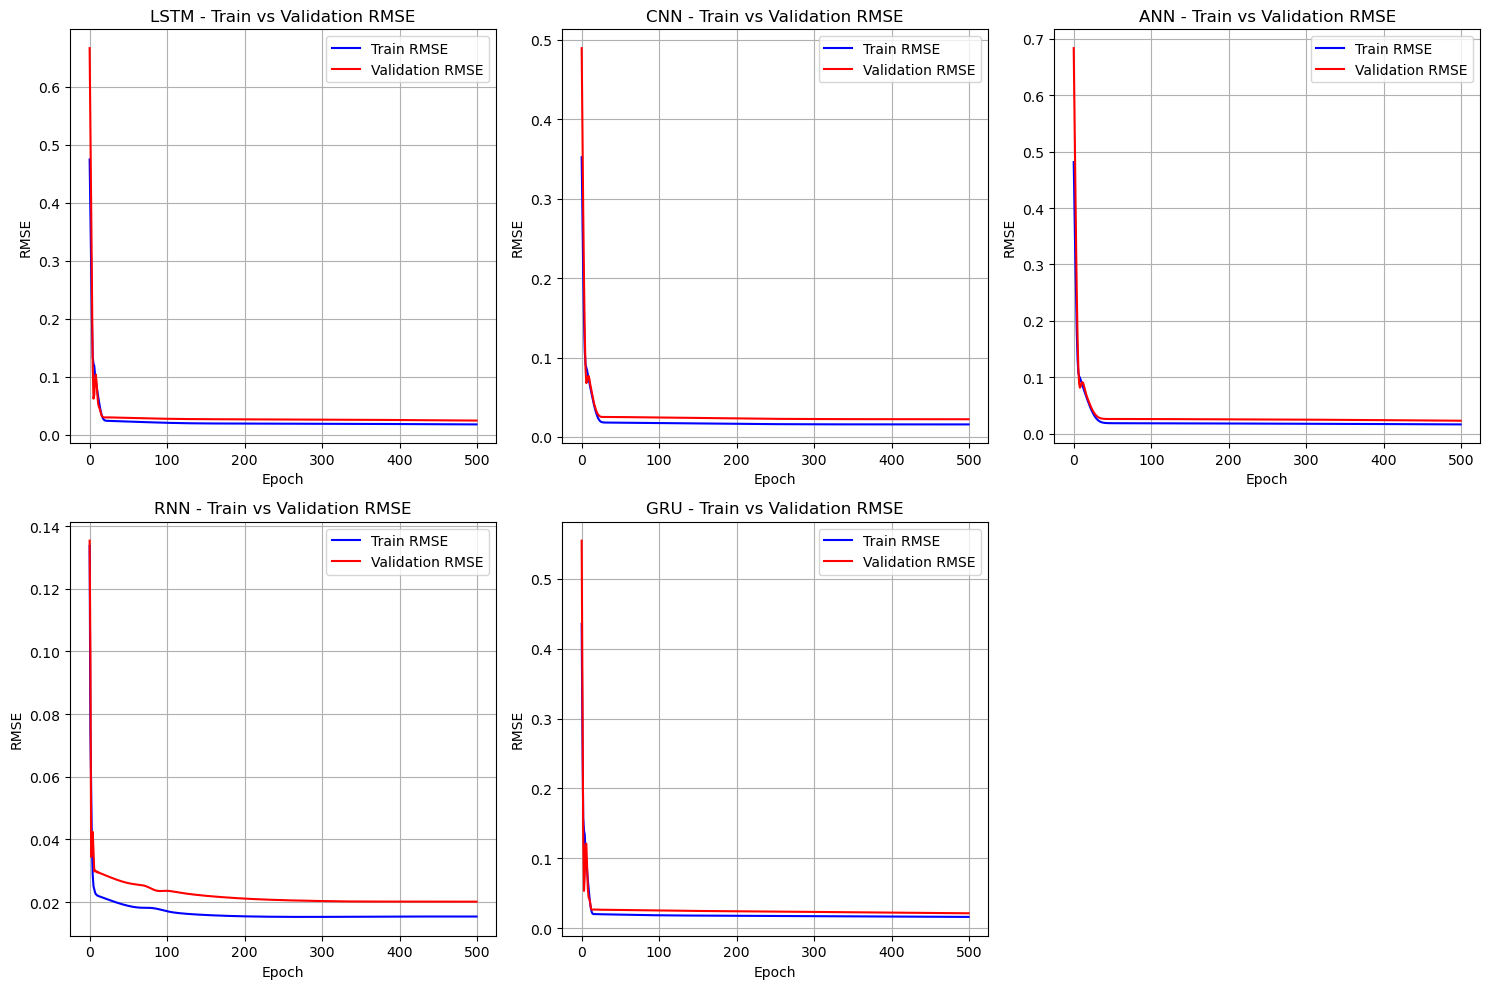

In [12]:
# 6. Visualization
# Separate RMSE plots for each model
plt.figure(figsize=(15, 10))
for idx, (name, (_, _, history)) in enumerate(results.items(), 1):
    plt.subplot(2, 3, idx)
    train_rmse = np.sqrt(history.history['loss'])
    plt.plot(train_rmse, label='Train RMSE', color='blue')
    
    if 'val_loss' in history.history:
        val_rmse = np.sqrt(history.history['val_loss'])
        plt.plot(val_rmse, label='Validation RMSE', color='red')
    
    plt.legend()
    plt.title(f'{name} - Train vs Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.grid(True)

plt.tight_layout()
plt.show()


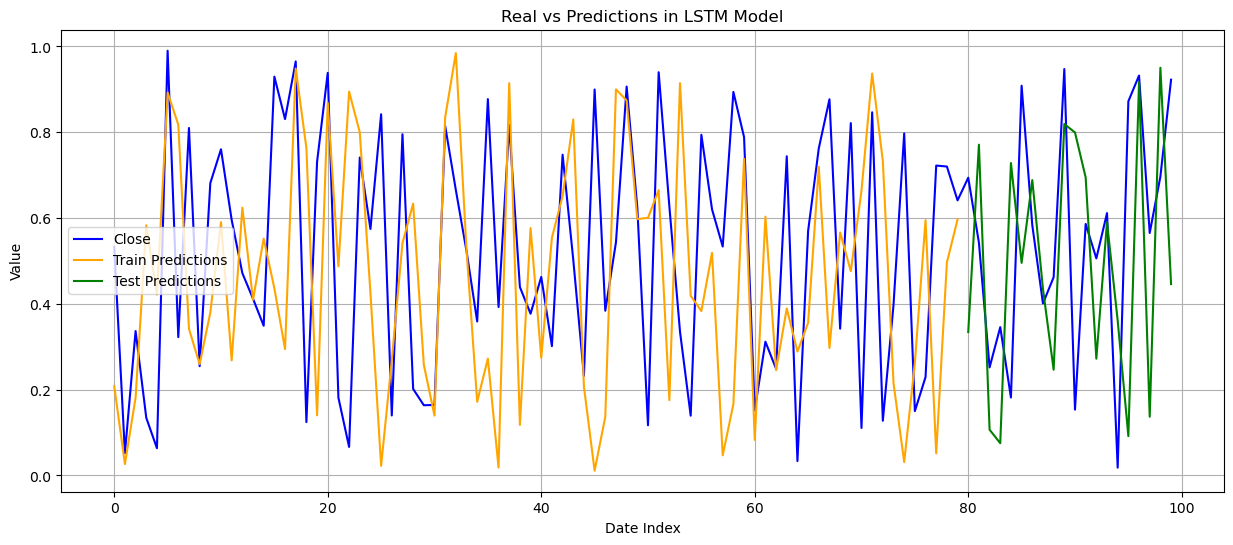

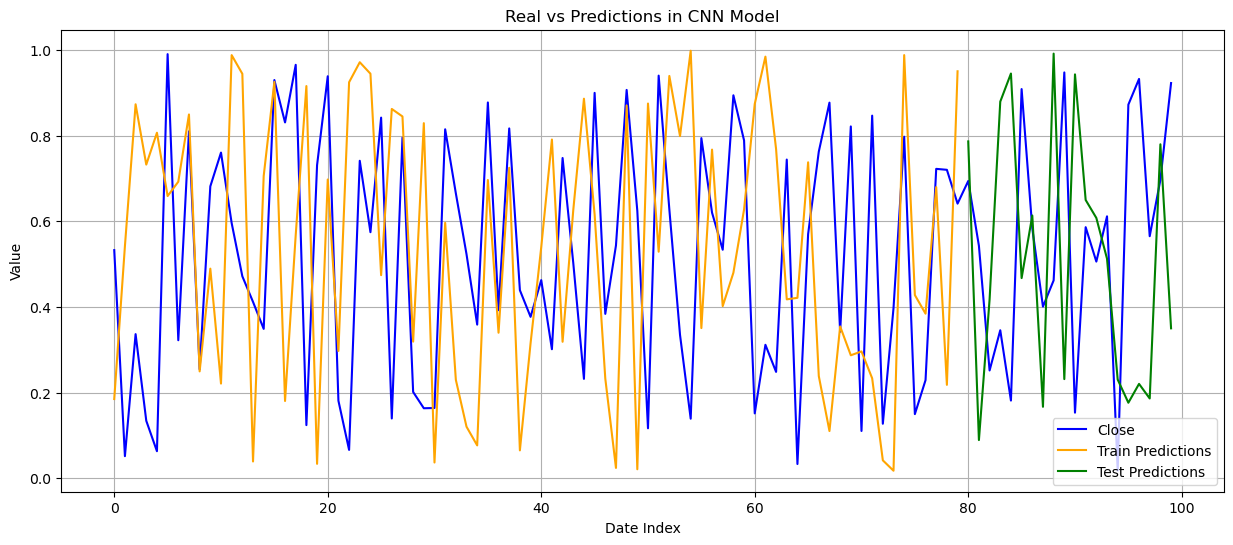

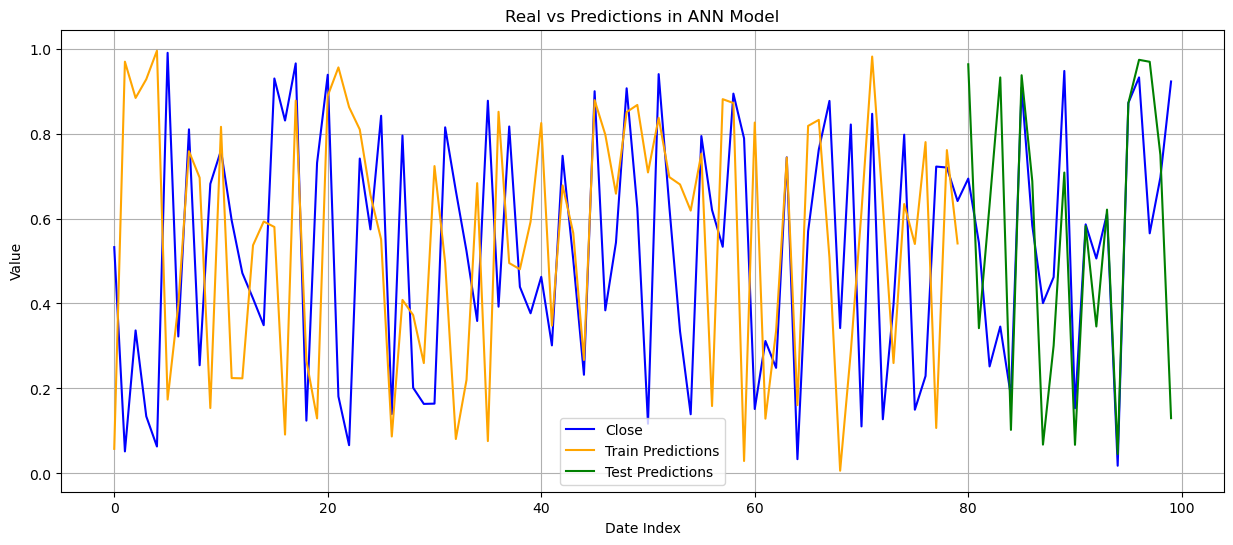

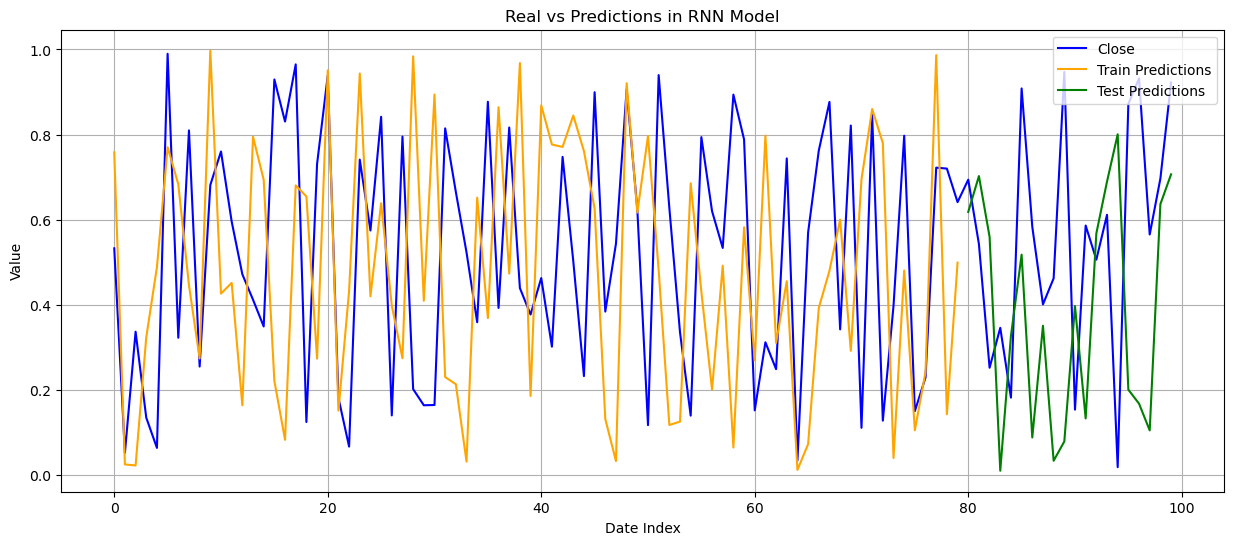

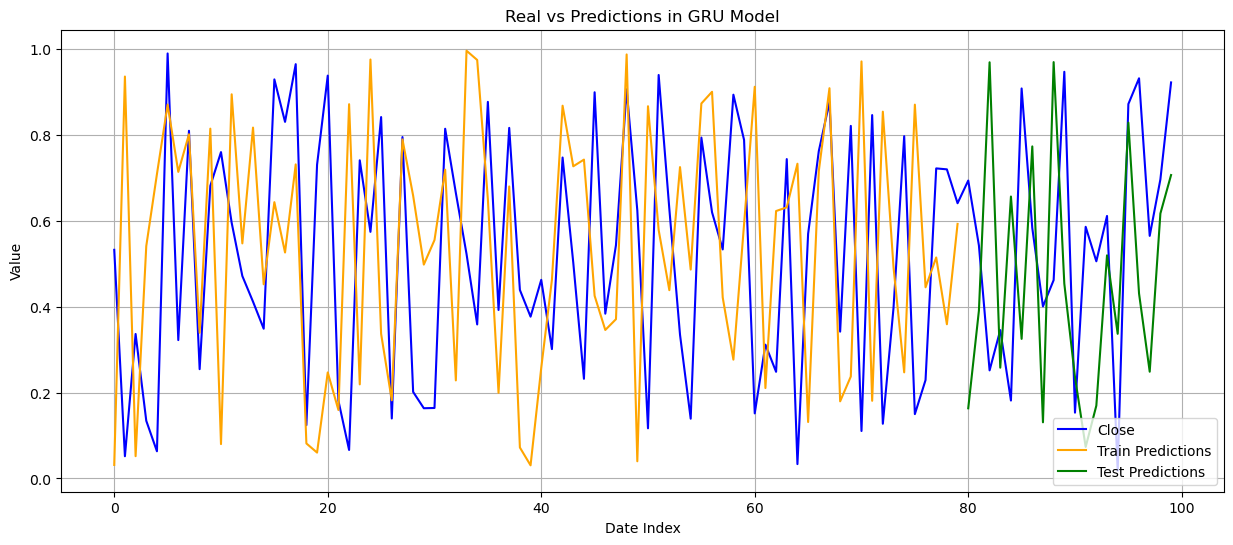

In [16]:
# Simulated data setup (replace with your actual data and results)
data = pd.DataFrame({'Close': np.random.rand(100)}, index=pd.date_range('2024-01-01', periods=100))  # Example data
y_train = np.random.rand(80)  # Example training data
y_test = np.random.rand(20)   # Example testing data
results = {
    'LSTM': [np.random.rand(80), np.random.rand(20)],
    'CNN': [np.random.rand(80), np.random.rand(20)],
    'ANN': [np.random.rand(80), np.random.rand(20)],
    'RNN': [np.random.rand(80), np.random.rand(20)],
    'GRU': [np.random.rand(80), np.random.rand(20)]
}

# Plotting code - one by one
models = ['LSTM', 'CNN', 'ANN', 'RNN', 'GRU']
for name in models:
    plt.figure(figsize=(15, 6))  # Create a new figure for each model
    # Plot actual close prices (raw data)
    plt.plot(np.arange(len(data)), data['Close'], label='Close', color='blue')
    # Plot train predictions
    plt.plot(np.arange(len(y_train)), results[name][0], label='Train Predictions', color='orange')
    # Plot test predictions
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), results[name][1], label='Test Predictions', color='green')
    plt.title(f'Real vs Predictions in {name} Model')
    plt.xlabel('Date Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()  # Display the plot immediately

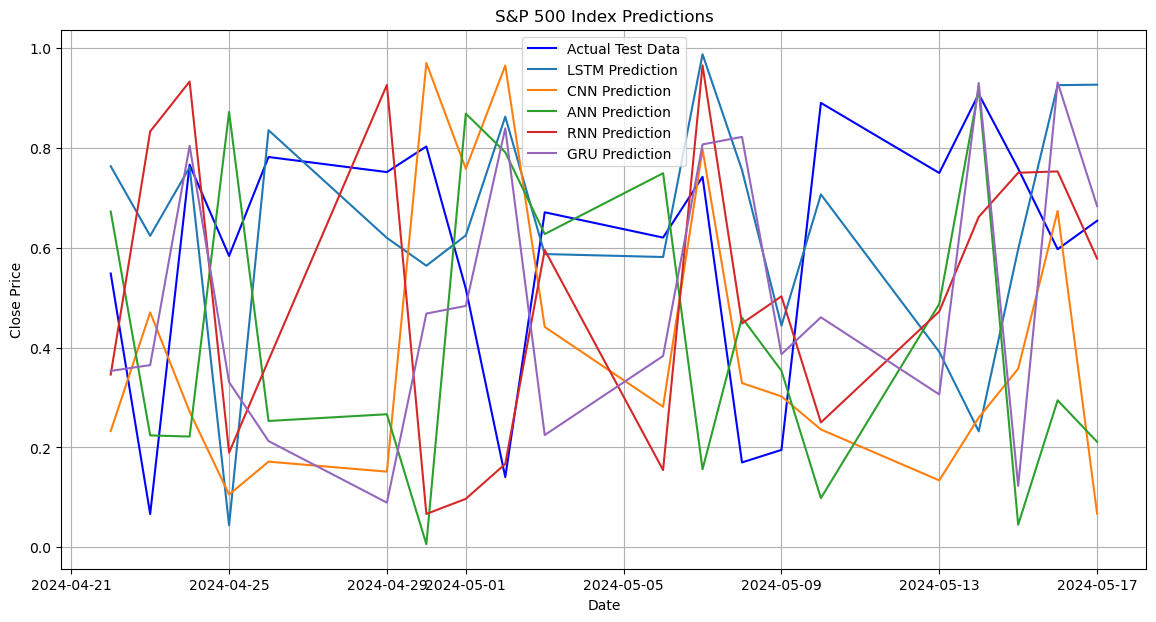

In [26]:


# Simulated data (replace with your actual data)
data = pd.DataFrame({'Close': np.random.rand(100)}, index=pd.date_range('2024-01-01', periods=100, freq='B'))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data['Close'].values.reshape(-1, 1))  # Fit scaler to full data
y_test = scaler.transform(data['Close'].values[-20:].reshape(-1, 1)).flatten()  # Last 20 days as test data
results = {
    'LSTM': [np.random.rand(80), np.random.rand(20)],  # [train_pred, test_pred]
    'CNN': [np.random.rand(80), np.random.rand(20)],
    'ANN': [np.random.rand(80), np.random.rand(20)],
    'RNN': [np.random.rand(80), np.random.rand(20)],
    'GRU': [np.random.rand(80), np.random.rand(20)]
}

# 6. Visualization
try:
    plt.figure(figsize=(14, 7))
    # Plot actual test data after inverse transformation
    plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Test Data', color='blue')
    # Plot predictions for each model after inverse transformation
    for name, (train_pred, test_pred) in results.items():
        plt.plot(data.index[-len(y_test):], scaler.inverse_transform(test_pred.reshape(-1, 1)), label=f'{name} Prediction')
    plt.legend()
    plt.title('S&P 500 Index Predictions')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)  # Added grid for better readability
    plt.show()

except Exception as e:
    print(f"Error occurred: {e}")